In [1]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore
from scipy.stats.mstats import winsorize
import scipy.stats
import statistics

warnings.filterwarnings('ignore')

In [2]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'useducation'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

usedu_df = pd.read_sql_query('select * from useducation',con=engine)

# no need for an open connection, 
# as we're only doing a single query
engine.dispose()

*** 
# Handling missing data

In [3]:
usedu_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1492 entries, 0 to 1491
Data columns (total 25 columns):
PRIMARY_KEY                     1492 non-null object
STATE                           1492 non-null object
YEAR                            1492 non-null int64
ENROLL                          1229 non-null float64
TOTAL_REVENUE                   1280 non-null float64
FEDERAL_REVENUE                 1280 non-null float64
STATE_REVENUE                   1280 non-null float64
LOCAL_REVENUE                   1280 non-null float64
TOTAL_EXPENDITURE               1280 non-null float64
INSTRUCTION_EXPENDITURE         1280 non-null float64
SUPPORT_SERVICES_EXPENDITURE    1280 non-null float64
OTHER_EXPENDITURE               1229 non-null float64
CAPITAL_OUTLAY_EXPENDITURE      1280 non-null float64
GRADES_PK_G                     1319 non-null float64
GRADES_KG_G                     1360 non-null float64
GRADES_4_G                      1361 non-null float64
GRADES_8_G                      1

In [4]:
usedu_df.isnull().sum()/usedu_df.shape[0]*100

PRIMARY_KEY                      0.000000
STATE                            0.000000
YEAR                             0.000000
ENROLL                          17.627346
TOTAL_REVENUE                   14.209115
FEDERAL_REVENUE                 14.209115
STATE_REVENUE                   14.209115
LOCAL_REVENUE                   14.209115
TOTAL_EXPENDITURE               14.209115
INSTRUCTION_EXPENDITURE         14.209115
SUPPORT_SERVICES_EXPENDITURE    14.209115
OTHER_EXPENDITURE               17.627346
CAPITAL_OUTLAY_EXPENDITURE      14.209115
GRADES_PK_G                     11.595174
GRADES_KG_G                      8.847185
GRADES_4_G                       8.780161
GRADES_8_G                       8.780161
GRADES_12_G                      8.780161
GRADES_1_8_G                     8.780161
GRADES_9_12_G                    8.780161
GRADES_ALL_G                    11.595174
AVG_MATH_4_SCORE                64.075067
AVG_MATH_8_SCORE                64.343164
AVG_READING_4_SCORE             64

In [5]:
usedu_df.head()

,PRIMARY_KEY,STATE,YEAR,ENROLL,TOTAL_REVENUE,FEDERAL_REVENUE,STATE_REVENUE,LOCAL_REVENUE,TOTAL_EXPENDITURE,INSTRUCTION_EXPENDITURE,...,GRADES_4_G,GRADES_8_G,GRADES_12_G,GRADES_1_8_G,GRADES_9_12_G,GRADES_ALL_G,AVG_MATH_4_SCORE,AVG_MATH_8_SCORE,AVG_READING_4_SCORE,AVG_READING_8_SCORE
0,1992_ALABAMA,ALABAMA,1992,NaN,2678885.0,304177.0,1659028.0,715680.0,2653798.0,1481703.0,...,57948.0,58025.0,41167.0,471564.0,196386.0,676174.0,208.327876,252.187522,207.963517,NaN
1,1992_ALASKA,ALASKA,1992,NaN,1049591.0,106780.0,720711.0,222100.0,972488.0,498362.0,...,9748.0,8789.0,6714.0,79117.0,30847.0,112335.0,NaN,NaN,NaN,258.859712
2,1992_ARIZONA,ARIZONA,1992,NaN,3258079.0,297888.0,1369815.0,1590376.0,3401580.0,1435908.0,...,55433.0,49081.0,37410.0,437127.0,175210.0,614881.0,215.253932,265.366278,206.212716,262.169895
3,1992_ARKANSAS,ARKANSAS,1992,NaN,1711959.0,178571.0,958785.0,574603.0,1743022.0,964323.0,...,34632.0,36011.0,27651.0,281338.0,123113.0,405259.0,210.206028,256.312090,208.634458,264.619665
4,1992_CALIFORNIA,CALIFORNIA,1992,NaN,26260025.0,2072470.0,16546514.0,7641041.0,27138832.0,14358922.0,...,418418.0,363296.0,270675.0,3286034.0,1372011.0,4717112.0,208.398961,260.892247,196.764414,NaN


In [6]:
# using pandas interpolation function to fill missing values
fill_cols = usedu_df.columns[3:]
states = usedu_df['STATE'].unique()

# save empty enteries stats
before_impute = (usedu_df.isnull().sum()/usedu_df.shape[0]*100).values

for state in states:
    usedu_df.loc[usedu_df['STATE'] == state, fill_cols] = usedu_df.loc[usedu_df['STATE'] == state, fill_cols].interpolate()

# print percent of empty cells before and after imputation
after_impute = (usedu_df.isnull().sum()/usedu_df.shape[0]*100).values
impute_ind = (usedu_df.isnull().sum()/usedu_df.shape[0]*100).index
print('{0:<30}      {1:<12}      {2:<12}'.format('', 'before', 'after')) 
for row in zip(impute_ind, before_impute, after_impute):
    print('{0:<30}      {1:<15.3}      {2:<15.3}'.format(*row))   

                                    before            after       
PRIMARY_KEY                         0.0                  0.0            
STATE                               0.0                  0.0            
YEAR                                0.0                  0.0            
ENROLL                              17.6                 14.1           
TOTAL_REVENUE                       14.2                 10.8           
FEDERAL_REVENUE                     14.2                 10.8           
STATE_REVENUE                       14.2                 10.8           
LOCAL_REVENUE                       14.2                 10.8           
TOTAL_EXPENDITURE                   14.2                 10.8           
INSTRUCTION_EXPENDITURE             14.2                 10.8           
SUPPORT_SERVICES_EXPENDITURE        14.2                 10.8           
OTHER_EXPENDITURE                   17.6                 14.1           
CAPITAL_OUTLAY_EXPENDITURE          14.2                 

In [7]:
# save empty enteries stats
before_impute = (usedu_df.isnull().sum()/usedu_df.shape[0]*100).values

# save a copy of the dataframe with missing values for 17.5.5
usedu_copy = usedu_df.copy()

# remaining missing values will be dropped
usedu_df.dropna(inplace=True)

# print percent of empty cells before and after imputation
after_impute = (usedu_df.isnull().sum()/usedu_df.shape[0]*100).values
impute_ind = (usedu_df.isnull().sum()/usedu_df.shape[0]*100).index
print('{0:<30}      {1:<12}      {2:<12}'.format('', 'before', 'after')) 
for row in zip(impute_ind, before_impute, after_impute):
    print('{0:<30}      {1:<12.3}      {2:<12.3}'.format(*row))

                                    before            after       
PRIMARY_KEY                         0.0               0.0         
STATE                               0.0               0.0         
YEAR                                0.0               0.0         
ENROLL                              14.1              0.0         
TOTAL_REVENUE                       10.8              0.0         
FEDERAL_REVENUE                     10.8              0.0         
STATE_REVENUE                       10.8              0.0         
LOCAL_REVENUE                       10.8              0.0         
TOTAL_EXPENDITURE                   10.8              0.0         
INSTRUCTION_EXPENDITURE             10.8              0.0         
SUPPORT_SERVICES_EXPENDITURE        10.8              0.0         
OTHER_EXPENDITURE                   14.1              0.0         
CAPITAL_OUTLAY_EXPENDITURE          10.8              0.0         
GRADES_PK_G                         3.28              0.0     

*** 
# Handling outliers

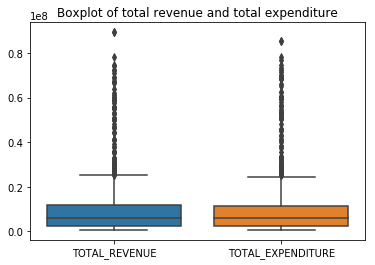

In [8]:
# visualizing outliers of TOTAL REVENUE/ EXPENDITURE

sns.boxplot(data= usedu_df[['TOTAL_REVENUE','TOTAL_EXPENDITURE']])
plt.title('Boxplot of total revenue and total expenditure')
plt.show()

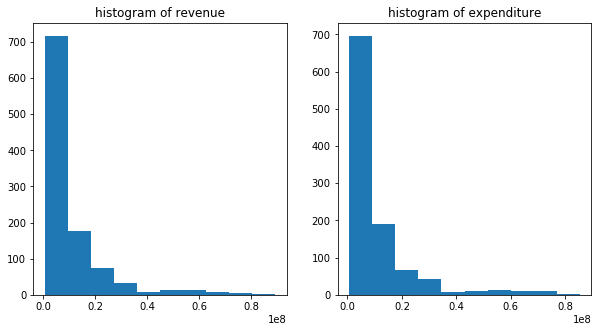

In [9]:
# histograms of TOTAL REVENUE/ EXPENDITURE
plt.figure(figsize=(10,5))

plt.subplot(1, 2, 1)
plt.hist(usedu_df['TOTAL_REVENUE'])
plt.title("histogram of revenue")

plt.subplot(1, 2, 2)
plt.hist(usedu_df['TOTAL_EXPENDITURE'])
plt.title("histogram of expenditure")

plt.show()


In [10]:
# z-score test

rev_z_scores = zscore(usedu_df['TOTAL_REVENUE'])
print('Total revenue outliers:')
for threshold in range(1,5):
    print("The score threshold is: {}".format(threshold))
    print("Number of outliers is: {}".format(len((np.where(rev_z_scores > threshold)[0]))))

print('_____________________________________________')
exp_z_scores = zscore(usedu_df['TOTAL_EXPENDITURE'])
print('Total expenditure outliers:')
for threshold in range(1,5):
    print("The score threshold is: {}".format(threshold))
    print("Number of outliers is: {}".format(len((np.where(exp_z_scores > threshold)[0]))))

Total revenue outliers:
The score threshold is: 1
Number of outliers is: 111
The score threshold is: 2
Number of outliers is: 49
The score threshold is: 3
Number of outliers is: 36
The score threshold is: 4
Number of outliers is: 16
_____________________________________________
Total expenditure outliers:
The score threshold is: 1
Number of outliers is: 107
The score threshold is: 2
Number of outliers is: 50
The score threshold is: 3
Number of outliers is: 38
The score threshold is: 4
Number of outliers is: 17


In [11]:
# Tukey's method for outliers

q75, q25 = np.percentile(usedu_df['TOTAL_REVENUE'] , [75 ,25])
iqr = q75 - q25

print('Total revenue outliers:')
for threshold in np.arange(1,5,0.5):
    min_val = q25 - (iqr*threshold)
    max_val = q75 + (iqr*threshold)
    print("The score threshold is: {}".format(threshold))
    print("Number of outliers is: {}".format(
        len((np.where((usedu_df['TOTAL_REVENUE'] > max_val) | (usedu_df['TOTAL_REVENUE'] < min_val))[0])) ))

print('_____________________________________________')
q75, q25 = np.percentile(usedu_df['TOTAL_EXPENDITURE'], [75 ,25])
iqr = q75 - q25

print('Total expenditure outliers:')
for threshold in np.arange(1,5,0.5):
    min_val = q25 - (iqr*threshold)
    max_val = q75 + (iqr*threshold)
    print("The score threshold is: {}".format(threshold))
    print("Number of outliers is: {}".format(
        len((np.where((usedu_df['TOTAL_EXPENDITURE'] > max_val) | (usedu_df['TOTAL_EXPENDITURE'] < min_val))[0])) ))

Total revenue outliers:
The score threshold is: 1.0
Number of outliers is: 126
The score threshold is: 1.5
Number of outliers is: 95
The score threshold is: 2.0
Number of outliers is: 62
The score threshold is: 2.5
Number of outliers is: 51
The score threshold is: 3.0
Number of outliers is: 46
The score threshold is: 3.5
Number of outliers is: 42
The score threshold is: 4.0
Number of outliers is: 36
The score threshold is: 4.5
Number of outliers is: 30
_____________________________________________
Total expenditure outliers:
The score threshold is: 1.0
Number of outliers is: 131
The score threshold is: 1.5
Number of outliers is: 100
The score threshold is: 2.0
Number of outliers is: 66
The score threshold is: 2.5
Number of outliers is: 51
The score threshold is: 3.0
Number of outliers is: 47
The score threshold is: 3.5
Number of outliers is: 44
The score threshold is: 4.0
Number of outliers is: 39
The score threshold is: 4.5
Number of outliers is: 34


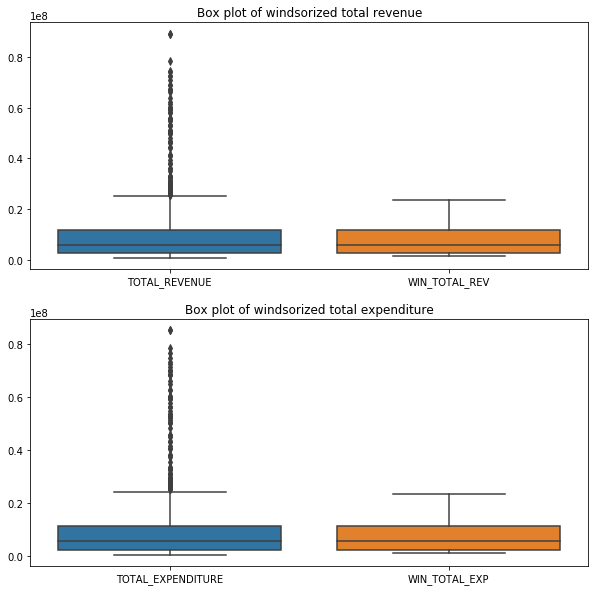

In [12]:
# Winsorization
plt.figure(figsize = (10,10))
winsorized_rev = winsorize(usedu_df['TOTAL_REVENUE'], (0.10, 0.10))
winsorized_exp = winsorize(usedu_df['TOTAL_EXPENDITURE'], (0.10, 0.10))

plt.subplot(2,1,1)
df = pd.DataFrame(list(zip(usedu_df['TOTAL_REVENUE'], winsorized_rev)), columns =['TOTAL_REVENUE', 'WIN_TOTAL_REV']) 
sns.boxplot(data=df)
plt.title("Box plot of windsorized total revenue")

plt.subplot(2,1,2)
df = pd.DataFrame(list(zip(usedu_df['TOTAL_EXPENDITURE'], winsorized_exp)), columns =['TOTAL_EXPENDITURE', 'WIN_TOTAL_EXP']) 
sns.boxplot(data=df)
plt.title("Box plot of windsorized total expenditure")
plt.show()

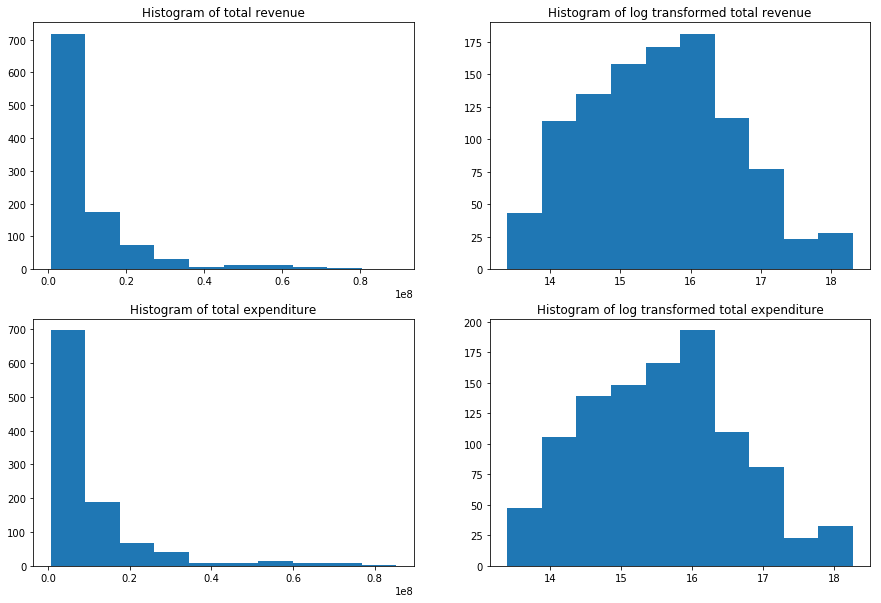

In [13]:
# Log transofrmation
plt.figure(figsize = (15,10))

plt.subplot(2,2,1)
plt.hist(usedu_df['TOTAL_REVENUE'])
plt.title("Histogram of total revenue")

plt.subplot(2,2,2)
plt.hist(np.log(usedu_df['TOTAL_REVENUE']))
plt.title("Histogram of log transformed total revenue")

plt.subplot(2,2,3)
plt.hist(usedu_df['TOTAL_EXPENDITURE'])
plt.title("Histogram of total expenditure")

plt.subplot(2,2,4)
plt.hist(np.log(usedu_df['TOTAL_EXPENDITURE']))
plt.title("Histogram of log transformed total expenditure")


plt.show()

In [14]:
# Effect of log trnasformation on outliers

q75, q25 = np.percentile(np.log(usedu_df['TOTAL_REVENUE']), [75 ,25])
iqr = q75 - q25

print('Total revenue outliers:')
for threshold in np.arange(1,5,0.5):
    min_val = q25 - (iqr*threshold)
    max_val = q75 + (iqr*threshold)
    print("The score threshold is: {}".format(threshold))
    print("Number of outliers is: {}".format(
        len((np.where((np.log(usedu_df['TOTAL_REVENUE']) > max_val) | (np.log(usedu_df['TOTAL_REVENUE']) < min_val))[0])) ))

print('_____________________________________________')
q75, q25 = np.percentile(np.log(usedu_df['TOTAL_EXPENDITURE']), [75 ,25])
iqr = q75 - q25

print('Total expenditure outliers:')
for threshold in np.arange(1,5,0.5):
    min_val = q25 - (iqr*threshold)
    max_val = q75 + (iqr*threshold)
    print("The score threshold is: {}".format(threshold))
    print("Number of outliers is: {}".format(
        len((np.where((np.log(usedu_df['TOTAL_EXPENDITURE']) > max_val) | (np.log(usedu_df['TOTAL_EXPENDITURE']) < min_val))[0])) ))



Total revenue outliers:
The score threshold is: 1.0
Number of outliers is: 28
The score threshold is: 1.5
Number of outliers is: 0
The score threshold is: 2.0
Number of outliers is: 0
The score threshold is: 2.5
Number of outliers is: 0
The score threshold is: 3.0
Number of outliers is: 0
The score threshold is: 3.5
Number of outliers is: 0
The score threshold is: 4.0
Number of outliers is: 0
The score threshold is: 4.5
Number of outliers is: 0
_____________________________________________
Total expenditure outliers:
The score threshold is: 1.0
Number of outliers is: 33
The score threshold is: 1.5
Number of outliers is: 0
The score threshold is: 2.0
Number of outliers is: 0
The score threshold is: 2.5
Number of outliers is: 0
The score threshold is: 3.0
Number of outliers is: 0
The score threshold is: 3.5
Number of outliers is: 0
The score threshold is: 4.0
Number of outliers is: 0
The score threshold is: 4.5
Number of outliers is: 0


The number of outliers decreased dramatically after log transformation

In [15]:
# Saving the log trnasformed data into the dataframe

usedu_df['LOG_TOTAL_REVENUE'] = np.log( usedu_df['TOTAL_REVENUE'])
usedu_df['LOG_TOTAL_EXPENDITURE'] = np.log( usedu_df['TOTAL_EXPENDITURE'])

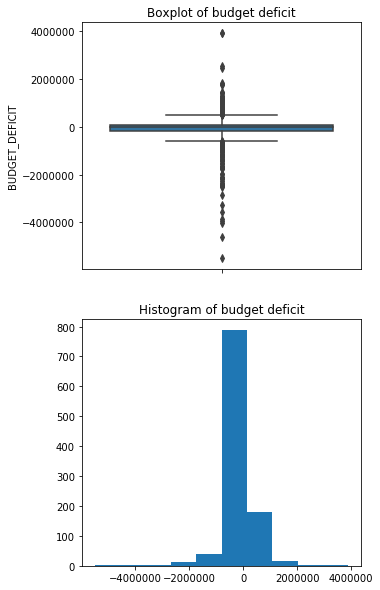

In [16]:
# Creating budget deficit column
plt.figure( figsize = (5,10))

usedu_df['BUDGET_DEFICIT'] = usedu_df['TOTAL_REVENUE'] - usedu_df['TOTAL_EXPENDITURE']
plt.subplot(2,1,1)
sns.boxplot( usedu_df['BUDGET_DEFICIT'], orient='v')
plt.title('Boxplot of budget deficit')

plt.subplot(2,1,2)
plt.hist(usedu_df['BUDGET_DEFICIT'])
plt.title('Histogram of budget deficit')
plt.show()

In [17]:
# Checking outliers in budget deficit using Tukey's method

q75, q25 = np.percentile(usedu_df['BUDGET_DEFICIT'] , [75 ,25])
iqr = q75 - q25

print('Budget deficit outliers:')
for threshold in np.arange(1,5,0.5):
    min_val = q25 - (iqr*threshold)
    max_val = q75 + (iqr*threshold)
    print("The score threshold is: {}".format(threshold))
    print("Number of outliers is: {}".format(
        len((np.where((usedu_df['BUDGET_DEFICIT'] > max_val) | (usedu_df['BUDGET_DEFICIT'] < min_val))[0])) ))

Budget deficit outliers:
The score threshold is: 1.0
Number of outliers is: 209
The score threshold is: 1.5
Number of outliers is: 144
The score threshold is: 2.0
Number of outliers is: 109
The score threshold is: 2.5
Number of outliers is: 89
The score threshold is: 3.0
Number of outliers is: 73
The score threshold is: 3.5
Number of outliers is: 65
The score threshold is: 4.0
Number of outliers is: 50
The score threshold is: 4.5
Number of outliers is: 39


In [18]:
# Checking outliers in budget deficit using z-score

budget_z_scores = zscore(usedu_df['BUDGET_DEFICIT'])
print('Budget deficit outliers:')
for threshold in range(1,5):
    print("The score threshold is: {}".format(threshold))
    print("Number of outliers is: {}".format(len((np.where(budget_z_scores > threshold)[0]))))

Budget deficit outliers:
The score threshold is: 1
Number of outliers is: 58
The score threshold is: 2
Number of outliers is: 16
The score threshold is: 3
Number of outliers is: 7
The score threshold is: 4
Number of outliers is: 4


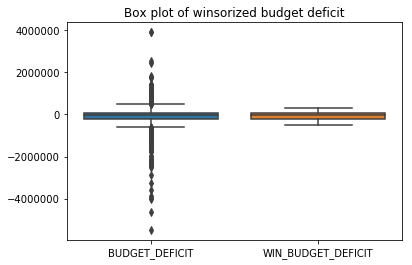

In [19]:
# Cannot log transform because of negative values
# Use winsorization
winsorized_budget = winsorize(usedu_df['BUDGET_DEFICIT'], (0.10, 0.10))

df = pd.DataFrame(list(zip(usedu_df['BUDGET_DEFICIT'], winsorized_budget)), columns =['BUDGET_DEFICIT', 'WIN_BUDGET_DEFICIT']) 
sns.boxplot(data=df)
plt.title("Box plot of winsorized budget deficit")
plt.show()

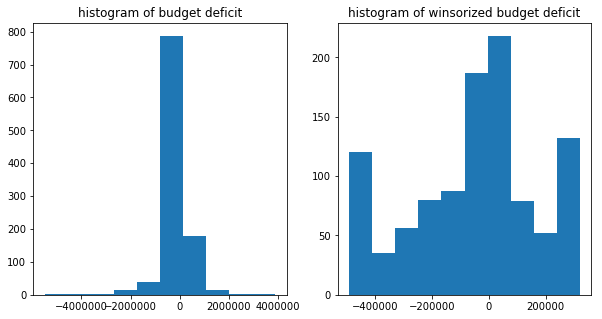

In [20]:
plt.figure( figsize = (10,5))

plt.subplot(1,2,1)
plt.hist(usedu_df['BUDGET_DEFICIT'])
plt.title('histogram of budget deficit')

plt.subplot(1,2,2)
plt.hist(winsorized_budget)
plt.title('histogram of winsorized budget deficit')

plt.show()

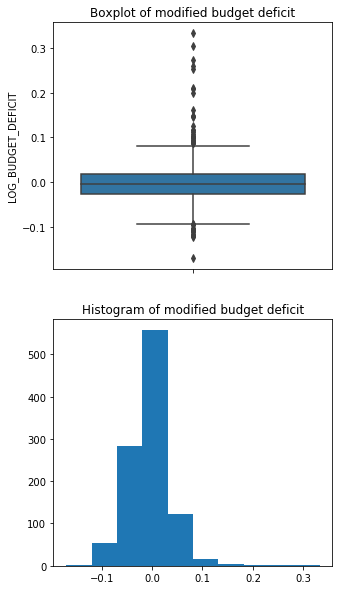

In [21]:
# Creating budget deficit column from modified revenue and expenditure values

plt.figure( figsize = (5,10))

usedu_df['LOG_BUDGET_DEFICIT'] = usedu_df['LOG_TOTAL_REVENUE'] - usedu_df['LOG_TOTAL_EXPENDITURE']
plt.subplot(2,1,1)
sns.boxplot( usedu_df['LOG_BUDGET_DEFICIT'], orient='v')
plt.title('Boxplot of modified budget deficit')

plt.subplot(2,1,2)
plt.hist(usedu_df['LOG_BUDGET_DEFICIT'])
plt.title('Histogram of modified budget deficit')
plt.show()

In [22]:
# Checking outliers in modified budget deficit using z-score

log_budget_z_scores = zscore(usedu_df['LOG_BUDGET_DEFICIT'])
print('Budget deficit outliers:')
for threshold in range(1,5):
    print("The score threshold is: {}".format(threshold))
    print("Number of outliers is: {}".format(len((np.where(log_budget_z_scores > threshold)[0]))))

Budget deficit outliers:
The score threshold is: 1
Number of outliers is: 111
The score threshold is: 2
Number of outliers is: 28
The score threshold is: 3
Number of outliers is: 12
The score threshold is: 4
Number of outliers is: 8


There seems to be more outliers when using modified revenue and expenditure

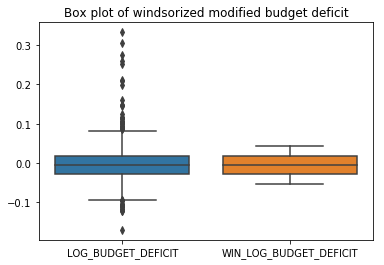

In [23]:
# Winsorize modified budget deficit
winsorized_log_budget = winsorize(usedu_df['LOG_BUDGET_DEFICIT'], (0.10, 0.10))

df = pd.DataFrame(list(zip(usedu_df['LOG_BUDGET_DEFICIT'], winsorized_log_budget)), columns =['LOG_BUDGET_DEFICIT', 'WIN_LOG_BUDGET_DEFICIT']) 
sns.boxplot(data=df)
plt.title("Box plot of windsorized modified budget deficit")
plt.show()

In [24]:
usedu_df[['BUDGET_DEFICIT', 'LOG_BUDGET_DEFICIT']].describe()

,BUDGET_DEFICIT,LOG_BUDGET_DEFICIT
count,1.046000e+03,1046.000000
mean,-8.971628e+04,-0.003362
std,6.065230e+05,0.045115
min,-5.487742e+06,-0.170369
25%,-1.949450e+05,-0.027178
50%,-1.583400e+04,-0.004871
75%,7.736350e+04,0.017054
max,3.897129e+06,0.332627


***
# Data Exploration

In [25]:
usedu_df.describe(include='all')

,PRIMARY_KEY,STATE,YEAR,ENROLL,TOTAL_REVENUE,FEDERAL_REVENUE,STATE_REVENUE,LOCAL_REVENUE,TOTAL_EXPENDITURE,INSTRUCTION_EXPENDITURE,...,GRADES_9_12_G,GRADES_ALL_G,AVG_MATH_4_SCORE,AVG_MATH_8_SCORE,AVG_READING_4_SCORE,AVG_READING_8_SCORE,LOG_TOTAL_REVENUE,LOG_TOTAL_EXPENDITURE,BUDGET_DEFICIT,LOG_BUDGET_DEFICIT
count,1046,1046,1046.000000,1.046000e+03,1.046000e+03,1.046000e+03,1.046000e+03,1.046000e+03,1.046000e+03,1.046000e+03,...,1.046000e+03,1.046000e+03,1046.000000,1046.000000,1046.000000,1046.000000,1046.000000,1046.000000,1.046000e+03,1046.000000
unique,1041,51,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,2008_VIRGINIA,DISTRICT_OF_COLUMBIA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,3,28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,2006.970363,9.312498e+05,1.016897e+07,8.849582e+05,4.715139e+06,4.568873e+06,1.025869e+07,5.302625e+06,...,2.797579e+05,8.764167e+05,235.269162,278.747113,219.099817,263.615681,15.575633,15.578995,-8.971628e+04,-0.003362
std,NaN,NaN,6.242782,1.104296e+06,1.288751e+07,1.261405e+06,6.105385e+06,5.989616e+06,1.308992e+07,6.879720e+06,...,3.325605e+05,1.040403e+06,9.632646,9.912572,7.804302,5.768169,1.051681,1.056940,6.065230e+05,0.045115
min,NaN,NaN,1993.000000,4.386600e+04,6.559710e+05,4.062200e+04,0.000000e+00,2.853100e+04,6.578090e+05,2.834840e+05,...,2.758000e+03,2.455400e+04,187.134670,232.831510,179.324956,236.379102,13.393872,13.396670,-5.487742e+06,-0.170369
25%,NaN,NaN,2002.000000,2.743105e+05,2.571806e+06,2.323988e+05,1.384262e+06,9.253550e+05,2.537691e+06,1.347766e+06,...,8.084075e+04,2.573745e+05,230.660761,273.383577,214.943439,259.956991,14.760115,14.746764,-1.949450e+05,-0.027178
50%,NaN,NaN,2007.000000,6.638440e+05,5.842360e+06,4.945290e+05,2.906463e+06,2.335014e+06,5.959529e+06,2.999999e+06,...,1.859055e+05,6.232765e+05,237.041971,280.862695,220.962973,264.517851,15.580645,15.600502,-1.583400e+04,-0.004871
75%,NaN,NaN,2012.000000,1.008680e+06,1.170678e+07,9.548370e+05,5.892033e+06,5.193129e+06,1.150621e+07,5.971732e+06,...,3.166840e+05,9.682915e+05,241.940254,285.257700,224.164324,267.663197,16.275679,16.258398,7.736350e+04,0.017054


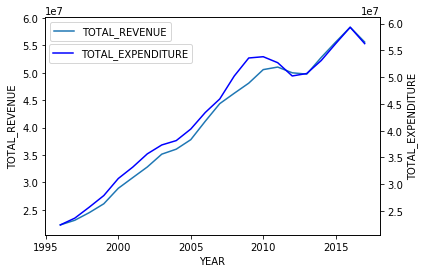

In [26]:
example_state = 'TEXAS'

sns.lineplot(x='YEAR', y='TOTAL_REVENUE', data=usedu_df[usedu_df['STATE'] == example_state], label='TOTAL_REVENUE')
ax2 = plt.twinx()
sns.lineplot(x='YEAR', y='TOTAL_EXPENDITURE', data=usedu_df[usedu_df['STATE'] == example_state], color="b", ax=ax2, label='TOTAL_EXPENDITURE')
plt.legend(bbox_to_anchor=(0.455,0.9))
plt.show()

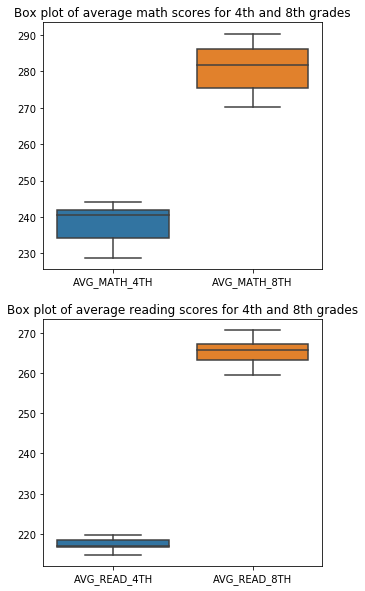

In [27]:
# compare reading vs. math
plt.figure( figsize = (5,10))
usedu_TX = usedu_df[ usedu_df.STATE == 'TEXAS']

plt.subplot(2,1,1)
df = pd.DataFrame(list(zip(usedu_TX['AVG_MATH_4_SCORE'], usedu_TX['AVG_MATH_8_SCORE'])), columns =['AVG_MATH_4TH', 'AVG_MATH_8TH']) 
sns.boxplot(data=df)
plt.title("Box plot of average math scores for 4th and 8th grades")

plt.subplot(2,1,2)
df = pd.DataFrame(list(zip(usedu_TX['AVG_READING_4_SCORE'], usedu_TX['AVG_READING_8_SCORE'])), columns =['AVG_READ_4TH', 'AVG_READ_8TH']) 
sns.boxplot(data=df)
plt.title("Box plot of average reading scores for 4th and 8th grades")
plt.show()


8th graders perform significantly better in math and reading than 4th graders.

In [28]:
usedu_TX.head()

,PRIMARY_KEY,STATE,YEAR,ENROLL,TOTAL_REVENUE,FEDERAL_REVENUE,STATE_REVENUE,LOCAL_REVENUE,TOTAL_EXPENDITURE,INSTRUCTION_EXPENDITURE,...,GRADES_9_12_G,GRADES_ALL_G,AVG_MATH_4_SCORE,AVG_MATH_8_SCORE,AVG_READING_4_SCORE,AVG_READING_8_SCORE,LOG_TOTAL_REVENUE,LOG_TOTAL_EXPENDITURE,BUDGET_DEFICIT,LOG_BUDGET_DEFICIT
252,1996_TEXAS,TEXAS,1996,3740260.0,22241369.0,1613462.0,9834742.0,10793165.0,22401797.0,11427564.0,...,1028958.0,3543973.0,228.712920,270.199578,216.862012,263.591742,16.917465,16.924652,-160428.0,-0.007187
304,1997_TEXAS,TEXAS,1997,3826366.0,23091567.0,1688975.0,9878849.0,11523743.0,23671010.0,12038459.0,...,1059416.0,3602194.0,229.701197,271.361187,216.879570,264.716313,16.954978,16.979762,-579443.0,-0.024784
355,1998_TEXAS,TEXAS,1998,3888061.0,24485263.0,1830474.0,10632566.0,12022223.0,25723965.0,12804069.0,...,1077158.0,3654935.0,230.689475,272.522797,216.897127,265.840884,17.013582,17.062934,-1238702.0,-0.049352
407,1999_TEXAS,TEXAS,1999,3933017.0,26096023.0,2161662.0,10802214.0,13132147.0,27883593.0,13486659.0,...,1095930.0,3700977.0,231.677752,273.684406,216.914684,266.965455,17.077293,17.143549,-1787570.0,-0.066256
460,2000_TEXAS,TEXAS,2000,3965971.0,28918934.0,2406972.0,12471856.0,14040106.0,31067935.0,15018072.0,...,1116572.0,3765402.0,232.666030,274.846016,216.932242,268.090027,17.180007,17.251687,-2149001.0,-0.071680


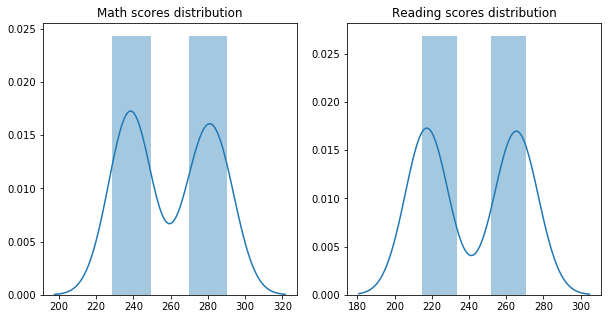

In [29]:
# Distribution of math and reading scores in Texas

plt.figure( figsize = (10,5))

math_scores = usedu_TX[['AVG_MATH_4_SCORE', 'AVG_MATH_8_SCORE']].values.flatten()
reading_scores = usedu_TX[['AVG_READING_4_SCORE', 'AVG_READING_8_SCORE']].values.flatten()

plt.subplot(1,2,1)
sns.distplot(math_scores)
plt.title('Math scores distribution')

plt.subplot(1,2,2)
sns.distplot(reading_scores)
plt.title('Reading scores distribution')

plt.show()

## The dataset copy needs to proceed interpolation! Needs to be fixed

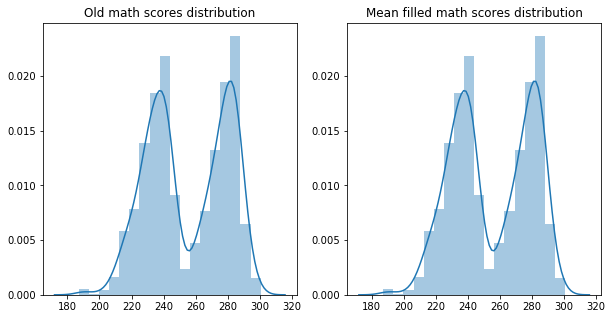

In [42]:
# Filling missing score values using MEAN and checking distribution

# maintain copy of original dataframe before dropping na's
usedu_copy2 = usedu_copy.copy()
usedu_copy2['AVG_MATH_4_SCORE'] = usedu_copy2.groupby('STATE')['AVG_MATH_4_SCORE'].transform(lambda x: x.fillna(x.mean()))
usedu_copy2['AVG_MATH_8_SCORE'] = usedu_copy2.groupby('STATE')['AVG_MATH_8_SCORE'].transform(lambda x: x.fillna(x.mean()))

math_scores = usedu_copy[['AVG_MATH_4_SCORE', 'AVG_MATH_8_SCORE']].dropna().values.flatten()
math_scores_mean_fill = usedu_copy2[['AVG_MATH_4_SCORE', 'AVG_MATH_8_SCORE']].dropna().values.flatten()

plt.figure( figsize = (10,5))
plt.subplot(1,2,1)
sns.distplot(math_scores)
plt.title('Old math scores distribution')

plt.subplot(1,2,2)
sns.distplot(math_scores_mean_fill)
plt.title('Mean filled math scores distribution')

plt.show()


ValueError: cannot convert float NaN to integer

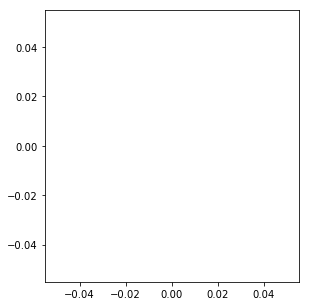

In [38]:
# Filling missing score values using MEDIAN and checking distribution

usedu_copy2 = usedu_copy.copy()
usedu_copy2['AVG_MATH_4_SCORE'] = usedu_copy2.groupby('STATE')['AVG_MATH_4_SCORE'].transform(lambda x: x.fillna(statistics.median(x)))
usedu_copy2['AVG_MATH_8_SCORE'] = usedu_copy2.groupby('STATE')['AVG_MATH_8_SCORE'].transform(lambda x: x.fillna(statistics.median(x)))

math_scores = usedu_copy[['AVG_MATH_4_SCORE', 'AVG_MATH_8_SCORE']].values.flatten()
math_scores_mean_fill = usedu_copy2[['AVG_MATH_4_SCORE', 'AVG_MATH_8_SCORE']].values.flatten()

plt.figure( figsize = (10,5))
plt.subplot(1,2,1)
sns.distplot(math_scores)
plt.title('Old math scores distribution')

plt.subplot(1,2,2)
sns.distplot(math_scores_mean_fill)
plt.title('Mean filled math scores distribution')

plt.show()

In [ ]:
# Filling missing score values using Linear Interpolation and checking distribution

### TO BE COMPLETED ###

In [ ]:
usedu_df.head()